In [2]:
import pandas as pd
import numpy as np
import matplotlib as plt
% matplotlib inline
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer
import requests
import os


# Data Wrangling
## 1- Gathering Data for the Project

In [3]:
# Dowloaded 'twitter_archive_enhanced.csv' 
df_1 = pd.read_csv('twitter-archive-enhanced.csv')

In [4]:
# Dowload 'image_predictions.tsv' programatically using Requests Library
folder_name = 'image_predictions'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
    
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)
with open(os.path.join(folder_name,
                      url.split('/')[-1]), mode='wb') as file:
    file.write(response.content)
df_2 = pd.read_csv('image_predictions/image-predictions.tsv', sep='\t')

In [6]:
# Twitter Data


# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

# NOTE TO STUDENT WITH MOBILE VERIFICATION ISSUES:
# df_1 is a DataFrame with the twitter_archive_enhanced.csv file. You may have to
# change line 17 to match the name of your DataFrame with twitter_archive_enhanced.csv
# NOTE TO REVIEWER: this student had mobile verification issues so the following
# Twitter API code was sent to this student from a Udacity instructor
# Tweet IDs for which to gather additional data via Twitter's API
tweet_ids = df_1.tweet_id.values
len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)


1: 892420643555336193
Fail
2: 892177421306343426
Fail
3: 891815181378084864
Fail
4: 891689557279858688
Fail
5: 891327558926688256
Fail
6: 891087950875897856
Fail
7: 890971913173991426
Fail
8: 890729181411237888
Fail
9: 890609185150312448
Fail
10: 890240255349198849
Fail
11: 890006608113172480
Fail
12: 889880896479866881
Fail
13: 889665388333682689
Fail
14: 889638837579907072
Fail
15: 889531135344209921
Fail
16: 889278841981685760
Fail
17: 888917238123831296
Fail
18: 888804989199671297
Fail
19: 888554962724278272
Fail
20: 888202515573088257
Fail
21: 888078434458587136
Fail
22: 887705289381826560
Fail
23: 887517139158093824
Fail
24: 887473957103951883
Fail
25: 887343217045368832
Fail
26: 887101392804085760
Fail
27: 886983233522544640
Fail
28: 886736880519319552
Fail
29: 886680336477933568
Fail
30: 886366144734445568
Fail
31: 886267009285017600
Fail
32: 886258384151887873
Fail
33: 886054160059072513
Fail
34: 885984800019947520
Fail
35: 885528943205470208
Fail
36: 885518971528720385
Fail
3

Fail
289: 838476387338051585
Fail
290: 838201503651401729
Fail
291: 838150277551247360
Fail
292: 838085839343206401
Fail
293: 838083903487373313
Fail
294: 837820167694528512
Fail
295: 837482249356513284
Fail
296: 837471256429613056
Fail
297: 837366284874571778
Fail
298: 837110210464448512
Fail
299: 837012587749474308
Fail
300: 836989968035819520
Fail
301: 836753516572119041
Fail
302: 836677758902222849
Fail
303: 836648853927522308
Fail
304: 836397794269200385
Fail
305: 836380477523124226
Fail
306: 836260088725786625
Fail
307: 836001077879255040
Fail
308: 835685285446955009
Fail
309: 835574547218894849
Fail
310: 835536468978302976
Fail
311: 835309094223372289
Fail
312: 835297930240217089
Fail
313: 835264098648616962
Fail
314: 835246439529840640
Fail
315: 835172783151792128
Fail
316: 835152434251116546
Fail
317: 834931633769889797
Fail
318: 834786237630337024
Fail
319: 834574053763584002
Fail
320: 834477809192075265
Fail
321: 834458053273591808
Fail
322: 834209720923721728
Fail
323: 8341

KeyboardInterrupt: 

In [5]:
df_3 = pd.read_json('tweet-json.txt', lines=True)

# 2- Assessing Data

The Purpose is to Detect and document at least eight (8) quality issues and two (2) tidiness issues

## Quality Issues

### df_1

1- Timestamps are formatted as object not date_time

2- tweet_id is formatted as int

3- Retweeted Status ID and User ID are formatted as float 

4- None in 'doggo, floofer, pupper and poppo' are not 'NaN'

5- Rating Denominator is not always 10 

6- Rating Numerator some values are inconsistent

7-	in_reply_to_status_id and in_reply_to_user_id are formatted as float 


### df_2

8- p1_dog, p2_dog and p3_dog are not Booleans

### df_3

9- Tweet_id has a different Name in df_3


## Tidiness Issues

1- No need for 3 different DataFrames, only one will suffice 
2- Dog stages were separated into multiple columns

In [6]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [7]:
df_1.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [8]:
df_1.doggo.head(5)

0    None
1    None
2    None
3    None
4    None
Name: doggo, dtype: object

In [9]:
df_1.doggo.value_counts()

None     2259
doggo      97
Name: doggo, dtype: int64

In [10]:
df_1.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [11]:
df_1.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [12]:
df_1.rating_numerator.value_counts(sort=True)

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [13]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [14]:
df_2.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [15]:
df_2.tail()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2074,892420643555336193,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False


In [16]:
df_2.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [17]:
df_2.p1.value_counts()

golden_retriever             150
Labrador_retriever           100
Pembroke                      89
Chihuahua                     83
pug                           57
chow                          44
Samoyed                       43
toy_poodle                    39
Pomeranian                    38
cocker_spaniel                30
malamute                      30
French_bulldog                26
miniature_pinscher            23
Chesapeake_Bay_retriever      23
seat_belt                     22
Siberian_husky                20
Staffordshire_bullterrier     20
German_shepherd               20
web_site                      19
Cardigan                      19
Maltese_dog                   18
beagle                        18
Shetland_sheepdog             18
teddy                         18
Eskimo_dog                    18
Rottweiler                    17
Lakeland_terrier              17
Shih-Tzu                      17
kuvasz                        16
Italian_greyhound             16
          

In [18]:
df_2.p2.value_counts()

Labrador_retriever                104
golden_retriever                   92
Cardigan                           73
Chihuahua                          44
Pomeranian                         42
Chesapeake_Bay_retriever           41
French_bulldog                     41
toy_poodle                         37
cocker_spaniel                     34
Siberian_husky                     33
miniature_poodle                   33
beagle                             28
Pembroke                           27
collie                             27
Eskimo_dog                         27
kuvasz                             26
Italian_greyhound                  22
Pekinese                           21
American_Staffordshire_terrier     21
toy_terrier                        20
malinois                           20
Samoyed                            20
chow                               20
miniature_pinscher                 20
Norwegian_elkhound                 19
Boston_bull                        19
Staffordshir

In [19]:
all_columns = pd.Series(list(df_1) + list(df_2) + list(df_3))
all_columns[all_columns.duplicated()]

17                 tweet_id
42    in_reply_to_status_id
44      in_reply_to_user_id
57                   source
dtype: object

In [20]:
df_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 31 columns):
contributors                     0 non-null float64
coordinates                      0 non-null float64
created_at                       2354 non-null datetime64[ns]
display_text_range               2354 non-null object
entities                         2354 non-null object
extended_entities                2073 non-null object
favorite_count                   2354 non-null int64
favorited                        2354 non-null bool
full_text                        2354 non-null object
geo                              0 non-null float64
id                               2354 non-null int64
id_str                           2354 non-null int64
in_reply_to_screen_name          78 non-null object
in_reply_to_status_id            78 non-null float64
in_reply_to_status_id_str        78 non-null float64
in_reply_to_user_id              78 non-null float64
in_reply_to_user_id_str          78 n

In [21]:
df_3.head()

,contributors,coordinates,created_at,display_text_range,entities,extended_entities,favorite_count,favorited,full_text,geo,...,possibly_sensitive_appealable,quoted_status,quoted_status_id,quoted_status_id_str,retweet_count,retweeted,retweeted_status,source,truncated,user
0,NaN,NaN,2017-08-01 16:23:56,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...",39467,False,This is Phineas. He's a mystical boy. Only eve...,NaN,...,0.0,NaN,NaN,NaN,8853,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
1,NaN,NaN,2017-08-01 00:17:27,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...",33819,False,This is Tilly. She's just checking pup on you....,NaN,...,0.0,NaN,NaN,NaN,6514,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
2,NaN,NaN,2017-07-31 00:18:03,"[0, 121]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891815175371796480, 'id_str'...",25461,False,This is Archie. He is a rare Norwegian Pouncin...,NaN,...,0.0,NaN,NaN,NaN,4328,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
3,NaN,NaN,2017-07-30 15:58:51,"[0, 79]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891689552724799489, 'id_str'...",42908,False,This is Darla. She commenced a snooze mid meal...,NaN,...,0.0,NaN,NaN,NaN,8964,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
4,NaN,NaN,2017-07-29 16:00:24,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891327551943041024, 'id_str'...",41048,False,This is Franklin. He would like you to stop ca...,NaN,...,0.0,NaN,NaN,NaN,9774,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."


In [22]:
df_3.columns

Index(['contributors', 'coordinates', 'created_at', 'display_text_range',
       'entities', 'extended_entities', 'favorite_count', 'favorited',
       'full_text', 'geo', 'id', 'id_str', 'in_reply_to_screen_name',
       'in_reply_to_status_id', 'in_reply_to_status_id_str',
       'in_reply_to_user_id', 'in_reply_to_user_id_str', 'is_quote_status',
       'lang', 'place', 'possibly_sensitive', 'possibly_sensitive_appealable',
       'quoted_status', 'quoted_status_id', 'quoted_status_id_str',
       'retweet_count', 'retweeted', 'retweeted_status', 'source', 'truncated',
       'user'],
      dtype='object')

In [23]:
df_3.id.head()

0    892420643555336193
1    892177421306343426
2    891815181378084864
3    891689557279858688
4    891327558926688256
Name: id, dtype: int64

In [24]:
df_3.id_str.head()

0    892420643555336192
1    892177421306343424
2    891815181378084864
3    891689557279858688
4    891327558926688256
Name: id_str, dtype: int64

# 3- Cleaning Data

The Purpose is section is to clean detected data issues 

In [25]:
df_1_clean = df_1.copy()
df_2_clean = df_2.copy()
df_3_clean = df_3.copy()


## Tidiness   / Quality

1- multiple columns for Dog Stages / None Values are not NaN

### Define
Convert None into NaN then Merge COlumns into one column

### Code

In [26]:

df_1_clean.doggo.replace('None',np.nan, inplace=True)
df_1_clean.pupper.replace('None',np.nan, inplace=True) 
df_1_clean.puppo.replace('None',np.nan, inplace=True) 
df_1_clean.floofer.replace('None',np.nan, inplace=True) 
df_1_clean.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo'],
      dtype='object')

In [27]:
df_1_clean = pd.melt(df_1_clean, id_vars=['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name'], value_name = 'dog_style' )

### Test

In [28]:
df_1_clean.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'variable', 'dog_style'],
      dtype='object')

In [29]:
df_1_clean.dog_style.value_counts()

pupper     257
doggo       97
puppo       30
floofer     10
Name: dog_style, dtype: int64


##  Quality
8- Tweet_id has a different Name in df_3

### Define
change id column to tweet_id in df_3

### Code

In [30]:
df_3_clean.rename(columns={'id': 'tweet_id'}, inplace=True)

### Test

In [31]:
df_3_clean.columns

Index(['contributors', 'coordinates', 'created_at', 'display_text_range',
       'entities', 'extended_entities', 'favorite_count', 'favorited',
       'full_text', 'geo', 'tweet_id', 'id_str', 'in_reply_to_screen_name',
       'in_reply_to_status_id', 'in_reply_to_status_id_str',
       'in_reply_to_user_id', 'in_reply_to_user_id_str', 'is_quote_status',
       'lang', 'place', 'possibly_sensitive', 'possibly_sensitive_appealable',
       'quoted_status', 'quoted_status_id', 'quoted_status_id_str',
       'retweet_count', 'retweeted', 'retweeted_status', 'source', 'truncated',
       'user'],
      dtype='object')


## Tidiness   / Quality
1- tweet_id is formatted as int
2- in_reply_to_status_id as int
3- in_reply_to_user_id as int
2- No need for 3 different DataFrames, only one will suffice 

### Define
Convert all "ids" as strings
Merge the three dataframes

### Code/

In [32]:
all_columns = pd.Series(list(df_1_clean) + list(df_2_clean))

all_columns[all_columns.duplicated()]

15    tweet_id
dtype: object

In [33]:
df_1_2 = pd.merge(df_1_clean, df_2_clean, on=['tweet_id'], how='left')

In [34]:
df_1_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9424 entries, 0 to 9423
Data columns (total 26 columns):
tweet_id                      9424 non-null int64
in_reply_to_status_id         312 non-null float64
in_reply_to_user_id           312 non-null float64
timestamp                     9424 non-null object
source                        9424 non-null object
text                          9424 non-null object
retweeted_status_id           724 non-null float64
retweeted_status_user_id      724 non-null float64
retweeted_status_timestamp    724 non-null object
expanded_urls                 9188 non-null object
rating_numerator              9424 non-null int64
rating_denominator            9424 non-null int64
name                          9424 non-null object
variable                      9424 non-null object
dog_style                     394 non-null object
jpg_url                       8300 non-null object
img_num                       8300 non-null float64
p1                            

In [35]:
all_columns = pd.Series(list(df_1_2) + list(df_3_clean))

all_columns[all_columns.duplicated()]

36                 tweet_id
39    in_reply_to_status_id
41      in_reply_to_user_id
54                   source
dtype: object

In [36]:
df_1_2.source.head()

0    <a href="http://twitter.com/download/iphone" r...
1    <a href="http://twitter.com/download/iphone" r...
2    <a href="http://twitter.com/download/iphone" r...
3    <a href="http://twitter.com/download/iphone" r...
4    <a href="http://twitter.com/download/iphone" r...
Name: source, dtype: object

In [37]:
df_3_clean.source.head()

0    <a href="http://twitter.com/download/iphone" r...
1    <a href="http://twitter.com/download/iphone" r...
2    <a href="http://twitter.com/download/iphone" r...
3    <a href="http://twitter.com/download/iphone" r...
4    <a href="http://twitter.com/download/iphone" r...
Name: source, dtype: object

In [38]:
df_1_2.tweet_id.astype('object', inplace=True)

0       892420643555336193
1       892177421306343426
2       891815181378084864
3       891689557279858688
4       891327558926688256
5       891087950875897856
6       890971913173991426
7       890729181411237888
8       890609185150312448
9       890240255349198849
10      890006608113172480
11      889880896479866881
12      889665388333682689
13      889638837579907072
14      889531135344209921
15      889278841981685760
16      888917238123831296
17      888804989199671297
18      888554962724278272
19      888202515573088257
20      888078434458587136
21      887705289381826560
22      887517139158093824
23      887473957103951883
24      887343217045368832
25      887101392804085760
26      886983233522544640
27      886736880519319552
28      886680336477933568
29      886366144734445568
               ...        
9394    666411507551481857
9395    666407126856765440
9396    666396247373291520
9397    666373753744588802
9398    666362758909284353
9399    666353288456101888
9

In [39]:
df_3_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 31 columns):
contributors                     0 non-null float64
coordinates                      0 non-null float64
created_at                       2354 non-null datetime64[ns]
display_text_range               2354 non-null object
entities                         2354 non-null object
extended_entities                2073 non-null object
favorite_count                   2354 non-null int64
favorited                        2354 non-null bool
full_text                        2354 non-null object
geo                              0 non-null float64
tweet_id                         2354 non-null int64
id_str                           2354 non-null int64
in_reply_to_screen_name          78 non-null object
in_reply_to_status_id            78 non-null float64
in_reply_to_status_id_str        78 non-null float64
in_reply_to_user_id              78 non-null float64
in_reply_to_user_id_str          78 n

In [40]:
df_1_2.tweet_id = df_1_2.tweet_id.apply(str)
df_1_2.in_reply_to_status_id = df_1_2.in_reply_to_status_id.apply(str)
df_1_2.in_reply_to_user_id = df_1_2.in_reply_to_user_id.apply(str)
df_3_clean.tweet_id = df_3_clean.tweet_id.apply(str)
df_3_clean.in_reply_to_status_id = df_3_clean.in_reply_to_status_id.apply(str)
df_3_clean.in_reply_to_user_id = df_3_clean.in_reply_to_user_id.apply(str)

df_1_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9424 entries, 0 to 9423
Data columns (total 26 columns):
tweet_id                      9424 non-null object
in_reply_to_status_id         9424 non-null object
in_reply_to_user_id           9424 non-null object
timestamp                     9424 non-null object
source                        9424 non-null object
text                          9424 non-null object
retweeted_status_id           724 non-null float64
retweeted_status_user_id      724 non-null float64
retweeted_status_timestamp    724 non-null object
expanded_urls                 9188 non-null object
rating_numerator              9424 non-null int64
rating_denominator            9424 non-null int64
name                          9424 non-null object
variable                      9424 non-null object
dog_style                     394 non-null object
jpg_url                       8300 non-null object
img_num                       8300 non-null float64
p1                           

In [41]:
df_1_2_3 = pd.merge(df_1_2, df_3_clean, on=['tweet_id','in_reply_to_status_id','in_reply_to_user_id','source'], how='left')

df_1_2_3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9424 entries, 0 to 9423
Data columns (total 53 columns):
tweet_id                         9424 non-null object
in_reply_to_status_id            9424 non-null object
in_reply_to_user_id              9424 non-null object
timestamp                        9424 non-null object
source                           9424 non-null object
text                             9424 non-null object
retweeted_status_id              724 non-null float64
retweeted_status_user_id         724 non-null float64
retweeted_status_timestamp       724 non-null object
expanded_urls                    9188 non-null object
rating_numerator                 9424 non-null int64
rating_denominator               9424 non-null int64
name                             9424 non-null object
variable                         9424 non-null object
dog_style                        394 non-null object
jpg_url                          8300 non-null object
img_num                          

## Quality

1- Timestamps are formatted as object not date_time

2- Retweeted Status ID and User ID are formatted as float 

3- Rating Denominator is not always 10 

4- Rating Numerator some values are inconsistent

s- Some Expanded URLs are duplicated
s- Missing Data in the 'expanded_urls' - 2297 I/O 2356

7- p1_dog, p2_dog and p3_dog are not Boolean

## Define
1- Convert Timestamps to Date_time

2- Convert Retweeted Status ID and User ID as Strings

3- Set all Rating Denominator as 10

4- Fix inconsistent Rating Numberators

5- Set p1_dog, p2_dog and p3_dog as Boolean

## Code

In [42]:
df_1_2_3.timestamp = pd.to_datetime(df_1_2_3['timestamp'])
df_1_2_3.retweeted_status_timestamp = pd.to_datetime(df_1_2_3['retweeted_status_timestamp'])
df_1_2_3.retweeted_status_id = df_1_2.retweeted_status_id.apply(str)
df_1_2_3.retweeted_status_user_id = df_1_2.retweeted_status_user_id.apply(str)
df_1_2_3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9424 entries, 0 to 9423
Data columns (total 53 columns):
tweet_id                         9424 non-null object
in_reply_to_status_id            9424 non-null object
in_reply_to_user_id              9424 non-null object
timestamp                        9424 non-null datetime64[ns]
source                           9424 non-null object
text                             9424 non-null object
retweeted_status_id              9424 non-null object
retweeted_status_user_id         9424 non-null object
retweeted_status_timestamp       724 non-null datetime64[ns]
expanded_urls                    9188 non-null object
rating_numerator                 9424 non-null int64
rating_denominator               9424 non-null int64
name                             9424 non-null object
variable                         9424 non-null object
dog_style                        394 non-null object
jpg_url                          8300 non-null object
img_num          

In [43]:
df_1_2_3.rating_denominator.describe()
df_1_2_3 = df_1_2_3[df_1_2_3.rating_denominator == 10]
df_1_2_3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9332 entries, 0 to 9423
Data columns (total 53 columns):
tweet_id                         9332 non-null object
in_reply_to_status_id            9332 non-null object
in_reply_to_user_id              9332 non-null object
timestamp                        9332 non-null datetime64[ns]
source                           9332 non-null object
text                             9332 non-null object
retweeted_status_id              9332 non-null object
retweeted_status_user_id         9332 non-null object
retweeted_status_timestamp       720 non-null datetime64[ns]
expanded_urls                    9112 non-null object
rating_numerator                 9332 non-null int64
rating_denominator               9332 non-null int64
name                             9332 non-null object
variable                         9332 non-null object
dog_style                        394 non-null object
jpg_url                          8228 non-null object
img_num          

In [44]:
df_1_2_3.rating_numerator.describe()

count    9332.000000
mean       12.237462
std        41.015877
min         0.000000
25%        10.000000
50%        11.000000
75%        12.000000
max      1776.000000
Name: rating_numerator, dtype: float64

In [45]:
df_1_2_3 = df_1_2_3[df_1_2_3.rating_numerator < 20]
df_1_2_3.rating_numerator.describe()

count    9296.000000
mean       10.706971
std         2.179413
min         0.000000
25%        10.000000
50%        11.000000
75%        12.000000
max        17.000000
Name: rating_numerator, dtype: float64

In [46]:
df_filter = df_1_2_3[df_1_2_3.rating_numerator == 0]
df_filter.info()
df_filter.head(8)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8 entries, 315 to 8084
Data columns (total 53 columns):
tweet_id                         8 non-null object
in_reply_to_status_id            8 non-null object
in_reply_to_user_id              8 non-null object
timestamp                        8 non-null datetime64[ns]
source                           8 non-null object
text                             8 non-null object
retweeted_status_id              8 non-null object
retweeted_status_user_id         8 non-null object
retweeted_status_timestamp       0 non-null datetime64[ns]
expanded_urls                    8 non-null object
rating_numerator                 8 non-null int64
rating_denominator               8 non-null int64
name                             8 non-null object
variable                         8 non-null object
dog_style                        0 non-null object
jpg_url                          8 non-null object
img_num                          8 non-null float64
p1          

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,possibly_sensitive,possibly_sensitive_appealable,quoted_status,quoted_status_id,quoted_status_id_str,retweet_count,retweeted,retweeted_status,truncated,user
315,835152434251116546,nan,nan,2017-02-24 15:40:31,"<a href=""http://twitter.com/download/iphone"" r...",When you're so blinded by your systematic plag...,nan,nan,NaT,https://twitter.com/dog_rates/status/835152434...,...,0.0,0.0,NaN,NaN,NaN,3443.0,False,NaN,False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
1016,746906459439529985,7.468859193875743e+17,4196983835.0,2016-06-26 03:22:31,"<a href=""http://twitter.com/download/iphone"" r...","PUPDATE: can't see any. Even if I could, I cou...",nan,nan,NaT,https://twitter.com/dog_rates/status/746906459...,...,0.0,0.0,NaN,NaN,NaN,336.0,False,NaN,False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
2671,835152434251116546,nan,nan,2017-02-24 15:40:31,"<a href=""http://twitter.com/download/iphone"" r...",When you're so blinded by your systematic plag...,nan,nan,NaT,https://twitter.com/dog_rates/status/835152434...,...,0.0,0.0,NaN,NaN,NaN,3443.0,False,NaN,False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
3372,746906459439529985,7.468859193875743e+17,4196983835.0,2016-06-26 03:22:31,"<a href=""http://twitter.com/download/iphone"" r...","PUPDATE: can't see any. Even if I could, I cou...",nan,nan,NaT,https://twitter.com/dog_rates/status/746906459...,...,0.0,0.0,NaN,NaN,NaN,336.0,False,NaN,False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
5027,835152434251116546,nan,nan,2017-02-24 15:40:31,"<a href=""http://twitter.com/download/iphone"" r...",When you're so blinded by your systematic plag...,nan,nan,NaT,https://twitter.com/dog_rates/status/835152434...,...,0.0,0.0,NaN,NaN,NaN,3443.0,False,NaN,False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
5728,746906459439529985,7.468859193875743e+17,4196983835.0,2016-06-26 03:22:31,"<a href=""http://twitter.com/download/iphone"" r...","PUPDATE: can't see any. Even if I could, I cou...",nan,nan,NaT,https://twitter.com/dog_rates/status/746906459...,...,0.0,0.0,NaN,NaN,NaN,336.0,False,NaN,False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
7383,835152434251116546,nan,nan,2017-02-24 15:40:31,"<a href=""http://twitter.com/download/iphone"" r...",When you're so blinded by your systematic plag...,nan,nan,NaT,https://twitter.com/dog_rates/status/835152434...,...,0.0,0.0,NaN,NaN,NaN,3443.0,False,NaN,False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
8084,746906459439529985,7.468859193875743e+17,4196983835.0,2016-06-26 03:22:31,"<a href=""http://twitter.com/download/iphone"" r...","PUPDATE: can't see any. Even if I could, I cou...",nan,nan,NaT,https://twitter.com/dog_rates/status/746906459...,...,0.0,0.0,NaN,NaN,NaN,336.0,False,NaN,False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."


In [47]:
df_1_2_3 = df_1_2_3[df_1_2_3.rating_numerator != 0]

In [48]:
df_1_2_3.rating_numerator.describe()

count    9288.000000
mean       10.716193
std         2.157567
min         1.000000
25%        10.000000
50%        11.000000
75%        12.000000
max        17.000000
Name: rating_numerator, dtype: float64

In [51]:
df_1_2_3.p1_dog = df_1_2_3.p1_dog.astype('bool')
df_1_2_3.p2_dog = df_1_2_3.p2_dog.astype('bool')
df_1_2_3.p3_dog = df_1_2_3.p3_dog.astype('bool')
df_1_2_3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9288 entries, 0 to 9423
Data columns (total 53 columns):
tweet_id                         9288 non-null object
in_reply_to_status_id            9288 non-null object
in_reply_to_user_id              9288 non-null object
timestamp                        9288 non-null datetime64[ns]
source                           9288 non-null object
text                             9288 non-null object
retweeted_status_id              9288 non-null object
retweeted_status_user_id         9288 non-null object
retweeted_status_timestamp       716 non-null datetime64[ns]
expanded_urls                    9080 non-null object
rating_numerator                 9288 non-null int64
rating_denominator               9288 non-null int64
name                             9288 non-null object
variable                         9288 non-null object
dog_style                        393 non-null object
jpg_url                          8200 non-null object
img_num          

# Analyze
1- Statistical Analysis of Ratings

In [93]:
df_1_2_3.rating_numerator.describe()

count    9288.000000
mean       10.716193
std         2.157567
min         1.000000
25%        10.000000
50%        11.000000
75%        12.000000
max        17.000000
Name: rating_numerator, dtype: float64

2-Most Dog Breeds tweeted about in P1_Dog

In [94]:
df_1_2_3.p1.value_counts()

golden_retriever             584
Labrador_retriever           388
Pembroke                     356
Chihuahua                    332
pug                          228
chow                         176
Samoyed                      172
toy_poodle                   156
Pomeranian                   148
cocker_spaniel               120
malamute                     120
French_bulldog               104
miniature_pinscher            92
Chesapeake_Bay_retriever      92
seat_belt                     88
Staffordshire_bullterrier     80
German_shepherd               80
Siberian_husky                76
web_site                      76
Cardigan                      76
beagle                        72
Eskimo_dog                    72
Shetland_sheepdog             72
Lakeland_terrier              68
Rottweiler                    68
Maltese_dog                   68
Shih-Tzu                      68
teddy                         68
Italian_greyhound             64
kuvasz                        60
          

3- Most Dog Names used

In [95]:
df_1_2_3.name.value_counts()

None          2884
a              216
Charlie         48
Lucy            44
Cooper          44
Oliver          44
Tucker          40
Lola            40
Penny           40
Winston         36
Bo              36
the             32
Sadie           32
Buddy           28
Daisy           28
Bailey          28
Toby            28
Jack            24
Rusty           24
Stanley         24
Jax             24
an              24
Scout           24
Milo            24
Koda            24
Bella           24
Leo             24
Oscar           24
Dave            24
Gus             20
              ... 
Humphrey         4
Socks            4
Bloo             4
Jackie           4
Kawhi            4
Benny            4
Thor             4
Ashleigh         4
Aqua             4
Biden            4
Sam              4
Georgie          4
Hall             4
Willow           4
Brudge           4
Mutt             4
Snickers         4
Patch            4
Blue             4
Petrick          4
Anthony          4
Reagan      

## Visulaization

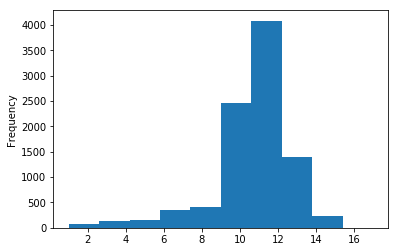

In [96]:
df_1_2_3.rating_numerator.plot.hist();

# Save to Csv

In [97]:
df_1_2_3.to_csv('We_Rate_Dogs.csv')